<a href="https://colab.research.google.com/github/avichhitwal/Non-Linear-Quantum-Computations-Using-Amplified-Encodings/blob/main/qnonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import qiskit as qk
import numpy as np
import qiskit_aer
from qiskit.primitives import BaseEstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorV2, QiskitRuntimeService, Session

backend = qiskit_aer.Aer.get_backend("aer_simulator")
estimator = EstimatorV2(backend)
estimator.options.default_precision = 0.001

# Fixed point iteration using Amplified Encodings

In this file we will define an amplified encoding for the function
$$
g(x) = \begin{bmatrix} 1 \\ 1 \end{bmatrix} - \frac18 \begin{bmatrix} (x_1 + x_2)^2 \\ (x_1 - x_2)^2 \end{bmatrix}.
$$
and use it to find the fixed point where $g(x) = x$.
An amplified encoding is a function that takes a block encoding of $x$ and constructs a block encoding of $g(x)$. For this we will need a data structure to hold the block encoding.

In [25]:
class BlockEncoding:

    def __init__(self, U: qk.QuantumCircuit, cU: qk.QuantumCircuit, norm: float):
        self.U = U        # non-controlled version of unitary of block encoding
        self.cU = cU      # controlled version of unitary of block encoding
        self.norm = norm  # normalization of block encoding

Usually the data structure would also need fields to store the projections $\Pi_1$ and $\Pi_2$ (or the circuits that implement them). Here, we always know that the projections will either be

1) $\langle 0|$ for the domain and $\operatorname{Id}_1$ for the codomain, when the block encoding has information efficiency 1, or
2) $\langle 000|$ for the domain and $\langle 00| \otimes \operatorname{Id}_1$ for the codomain.

We will refer back to this as projections 1) and 2) later. Controlled versions for all circuits are implemented manually for efficiency.

We could for example define a block encoding for our starting value $x^{(0)} = [1 \;1]^T$ with projections 1) like the following.

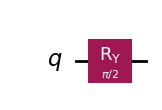

In [26]:
U_x = qk.QuantumCircuit(1, name="U_x0")
U_x.ry(2 * np.arctan(1/1), 0)
cU_x = qk.QuantumCircuit(2, name="cU_x0")
cU_x.cry(2 * np.arctan(1/1), 0, 1)

x0 = BlockEncoding(U_x, cU_x, np.sqrt(2))

U_x.draw("mpl")

We now use this to implement a block encoding of $g(x)$

In [27]:
U_g = qk.QuantumCircuit(3)

The last qubit is used to control the addition of the constant and quadratic terms. We use a rotation so that the qubit is in state $|1\rangle$ with probability
$$\frac{\big|[1 \; 1]^T\big|}{|g(x)|}$$

In [28]:
angle = 2 * np.arctan(np.sqrt(np.sqrt(2) / ((2/8) * x0.norm ** 2)))
U_g.ry(angle, 2)

If it is we want to prepare the vector $[1\; 1]^T$ in the first register, which we do using a Hadamard gate.

In [41]:
U_g.ch(2, 0)

Otherwise, we flip the sign using a $\mathrm{Z}$ gate (to get subtraction instead of addition) and prepare two copies of $x^{0}$.

In [43]:
U_g.x(2)
U_g.z(2)
U_g.append(x0.cU, [2, 0])
U_g.append(x0.cU, [2, 1])

We then apply the matrix
$$\begin{bmatrix} 1 & \phantom{-}1 \\ 1 & -1\end{bmatrix}$$
to both copies using two more Hadamard gates, giving us two copies of
$$\begin{bmatrix} x_1 + x_2 \\ x_1 - x_2 \end{bmatrix}.$$
These are finally multiplied using a CNOT gate.

In [44]:
U_g.ch(2, 0)
U_g.ch(2, 1)
U_g.ccx(2, 0, 1)

Lastly, we reverse the rotation of the ancilla qubit.

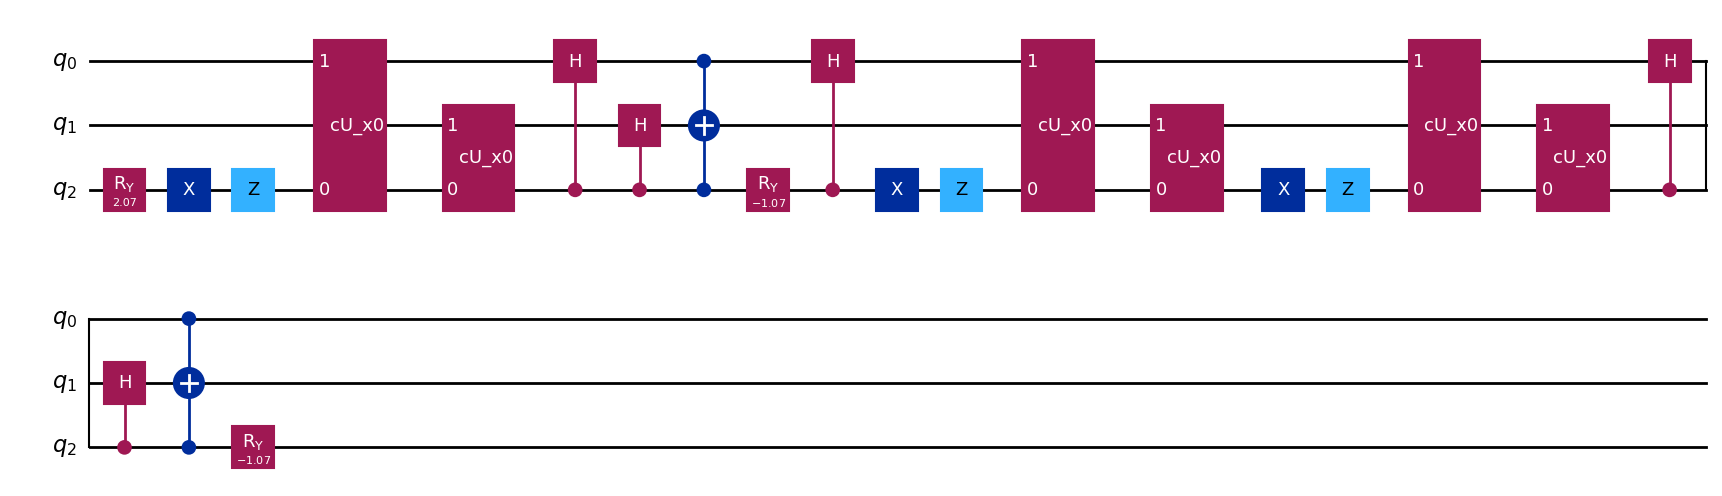

In [45]:
U_g.ry(-(np.pi - angle), 2)
U_g.draw("mpl")

The first qubit now contains the vector $g(x^{(0)})$ (up to some normalization), when the last two qubits are both zero, i.e. the projections are given by 2). We can use this knowledge to estimate the information efficiency of the constructed encoding.

In [46]:
def estimate_ie(U: qk.QuantumCircuit, estimator: Estimator) -> float:
    zero = qk.quantum_info.SparsePauliOp(["I", "Z"], coeffs=[0.5, 0.5])
    obs = qk.quantum_info.SparsePauliOp("I" * (U.num_qubits - 3)) ^ zero ^ zero ^ qk.quantum_info.SparsePauliOp("I")
    circ = qk.transpile(U, estimator._backend, optimization_level=3)
    obs = obs.apply_layout(circ.layout)
    return np.sqrt(estimator.run([(circ, obs)]).result()[0].data.evs)


ie = estimate_ie(U_g, estimator)
ie

0.23335595128472728

The next step is to amplify the encoding. We try here to obtain an encoding with information efficiency 1, since this would mean that we can drop the projections of the last two qubits. They would be in the image of the projection anyways.

Amplitude amplification with $k$ iterations leads to an information efficiency of $\sin(k \sin^{-1}(\eta))$, so we need the information efficiency to be $\pi/(2k)$ for some odd $k$. This is not the case here, so we write a function constructing a block encoding of $g(x)$, that can optionally remove some information efficiency.

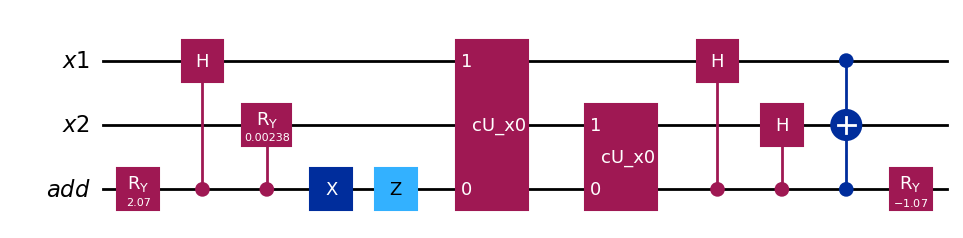

In [49]:
def block_encoding_g(x: BlockEncoding, target_norm: float | None = None) -> BlockEncoding:
    norm = np.sqrt(2) + (2/8) * x.norm ** 2

    if target_norm is not None:
        # assert target_norm > norm
        if target_norm <= norm:
            target_norm = norm + 1e-6
        diff = target_norm - norm
        angle = 2 * np.arctan(np.sqrt((np.sqrt(2) + diff) / ((2/8) * x.norm ** 2)))
        angle2 = 2 * np.arccos(np.sqrt(2) / (np.sqrt(2) + diff))
        norm = target_norm
    else:
        angle = 2 * np.arctan(np.sqrt(np.sqrt(2) / ((2/8) * x.norm ** 2)))

    c = qk.QuantumRegister(1, name="c")
    x1 = qk.QuantumRegister(1, name="x1")
    x2 = qk.QuantumRegister(1, name="x2")
    add = qk.QuantumRegister(1, name="add")
    a = qk.QuantumRegister(x.cU.num_qubits - 2, name="a")  # Register to give x the ancilla space it needs

    # Define non-controlled circuit
    U = qk.QuantumCircuit(x1, x2, add, a, name="U_g")
    U.ry(angle, add)
    U.ch(add, x1)

    # Here, in the case where the add bit is |1> we rotate the bit used to store the second copy of x.
    # This is normally unused in this case.
    if target_norm is not None:
        U.cry(angle2, add, x2)

    U.x(add)
    U.z(add)
    U.append(x.cU, [add, x1[0]] + a[:x.cU.num_qubits - 2])
    U.append(x.cU, [add, x2[0]] + a[-(x.cU.num_qubits - 2):])
    U.ch(add, x1)
    U.ch(add, x2)
    U.ccx(add, x1, x2)
    U.ry(-(np.pi - angle), add)

    # Define controlled circuit analogously
    cU = qk.QuantumCircuit(c, x1, x2, add, a, name="cU_g")
    cU.cry(angle, c, add)
    cU.ch(add, x1)
    if target_norm is not None:
        cU.cry(angle2, add, x2)
    cU.cx(c, add)
    cU.z(add)
    cU.append(x.cU, [add, x1[0]] + a[:x.cU.num_qubits - 2])
    cU.append(x.cU, [add, x2[0]] + a[-(x.cU.num_qubits - 2):])
    cU.ch(add, x1)
    cU.ch(add, x2)
    cU.ccx(add, x1, x2)
    cU.cry(-(np.pi - angle), c, add)

    return BlockEncoding(U, cU, norm)

x1 = block_encoding_g(x0, (np.sqrt(2) + (2/8) * 2) * ie / 0.5)
x1.U.draw("mpl")

This now has information efficiency $0.5$ so we can use $k = 3$ steps of amplitude amplification to get an encoding with perfrect information efficiency.

In [50]:
estimate_ie(x1.U, estimator)

0.58334723792952

Let us define a function that chooses $k$ and performs the above steps automatically.

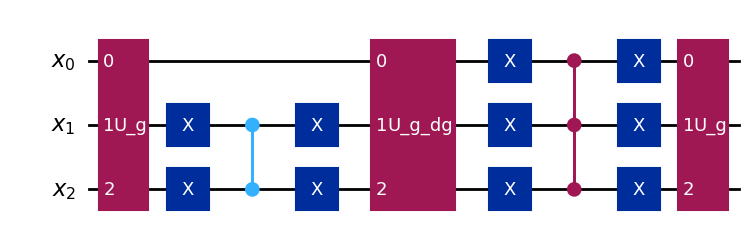

In [54]:
def amplify(inp: BlockEncoding, k: int) -> BlockEncoding:

    c = qk.QuantumRegister(1, name="c")
    x = qk.QuantumRegister(inp.U.num_qubits, name="x")
    a = qk.QuantumRegister(1, name="a")

    # Define non-controlled unitary
    U = qk.QuantumCircuit(x)
    for i in range(k):
        if i % 2 == 0:
            U.append(inp.U, x[:])
        else:
            U.append(inp.U.inverse(), x[:])

        if i == (k - 1):
            if ((k - 1) / 2) % 2 == 1:
                U.append(qk.circuit.library.GlobalPhaseGate(np.pi))
        elif i % 2 == 1:
            # Flip phase if first three qubits are zero
            U.x([x[0], x[1], x[2]])
            U.ccz(x[0], x[1], x[2])
            U.x([x[0], x[1], x[2]])
        else:
            # Flip phase if second and third qubits are zero
            U.x([x[1], x[2]])
            U.cz(x[1], x[2])
            U.x([x[1], x[2]])

    # Define controlled unitary
    if inp.U.num_qubits == 3:
        cU = qk.QuantumCircuit(c, x, a)
    else:
        cU = qk.QuantumCircuit(c, x)
        # After step 1 we can reuse an ancilla bit
        a = x[-1:]
    for i in range(k):
        if i % 2 == 0:
            if i == k - 1:
                cU.append(inp.cU, c[:] + x[:])
            else:
                cU.append(inp.U, x[:])
        else:
            cU.append(inp.U.inverse(), x[:])
        if i == (k - 1):
            if ((k - 1) / 2) % 2 == 1:
                cU.z(c)
        elif i % 2 == 1:
            cU.x([x[0], x[1], x[2]])
            cU.rccx(x[0], x[1], a[0])
            cU.ccz(c, a[0], x[2])
            cU.rccx(x[0], x[1], a[0])
            cU.x([x[0], x[1], x[2]])
        else:
            cU.x([x[1], x[2]])
            cU.ccz(c, x[1], x[2])
            cU.x([x[1], x[2]])

    return BlockEncoding(U, cU, inp.norm * np.sin(np.pi/(2 * k)))

x1 = amplify(x1, 3)
x1.U.draw("mpl")

In [55]:
estimate_ie(x1.U, estimator)

0.9553753189192193

Let us define a function that chooses $k$ and performs the above steps automatically.

In [56]:
def g(x: BlockEncoding, estimator: Estimator):
    res = block_encoding_g(x)
    if type(estimator) is float:
        ie = estimator
    else:
        ie = estimate_ie(res.U, estimator)
    k = 2 * int(np.ceil(0.25 * (np.pi / np.arcsin(ie) - 2))) + 1
    add_subnorm = np.sin(np.pi/(2 * k)) / ie
    target_norm = res.norm / add_subnorm
    res = block_encoding_g(x, target_norm)
    return amplify(res, k)

We run a few iterations to verify our results.

In [57]:
N = 3
x = x0
x_ref = np.array([1, 1])
for i in range(N):
    x = g(x, estimator)

    # Sample the encoding x
    obs0 = qk.quantum_info.SparsePauliOp(["I" * x.U.num_qubits, "I" * (x.U.num_qubits - 1) + "Z"], coeffs=[0.5, 0.5])
    circ = qk.transpile(x.U, estimator._backend, optimization_level=3)
    obs0 = obs0.apply_layout(circ.layout)
    result = estimator.run([(circ, obs0)]).result()
    p = np.array([result[0].data.evs, 1-result[0].data.evs])
    print(f"x{i+1} (simulated): {np.sqrt(p) * x.norm}")

    x_ref = np.array([1 - 0.125 * (x_ref[0] + x_ref[1]) ** 2, 1 - 0.125 * (x_ref[0] - x_ref[1]) ** 2])
    print(f"x{i+1} (reference): {x_ref}")

x1 (simulated): [0.5005316  1.00039112]
x1 (reference): [0.5 1. ]
x2 (simulated): [0.72058954 0.96877753]
x2 (reference): [0.71875 0.96875]
x3 (simulated): [0.64781924 0.99010949]
x3 (reference): [0.64404297 0.9921875 ]


Note, that while the number of qubits grows with each iteration, it only does so linearly. The runtime increases roughly exponentially. We could also give each instance of $U_x$ its own memory in the definition of `block_encoding_g`, which would lead to exponential memory growth, but linear circuit depth.

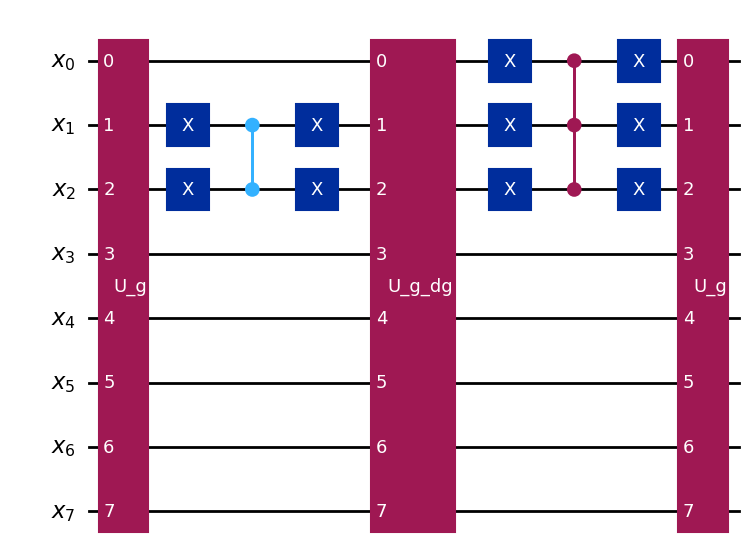

In [58]:
x.U.draw("mpl")